# DSA 5303 Financial Project

- source codes are obtained from https://medium.com/python-data/effient-frontier-in-python-34b0c3043314

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

import time
import re
import quandl
import seaborn as sns
import scipy.optimize as sco


#Default plotting parameters
FONTSIZE = 18
plt.rcParams['figure.figsize'] = (12, 11)
plt.rcParams['font.size'] = FONTSIZE
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [3]:
quandl.ApiConfig.api_key = "tKDbXSjzUvvchHUM-F4m"
stocks = ['AAPL','MSFT','IBM','WMT','GS','JPM']

data = quandl.get_table('WIKI/PRICES', ticker = stocks,
                        qopts = { 'columns': ['date', 'ticker', 'adj_close'] },
                        date = { 'gte': '2014-1-1', 'lte': '2020-12-31' }, paginate=True)
data.head()

,date,ticker,adj_close
None,,,
0,2018-03-27,WMT,86.05
1,2018-03-26,WMT,87.50
2,2018-03-23,WMT,85.42
3,2018-03-22,WMT,87.14
4,2018-03-21,WMT,88.18


In [4]:
df = data.set_index('date')
df.head()

,ticker,adj_close
date,,
2018-03-27,WMT,86.05
2018-03-26,WMT,87.50
2018-03-23,WMT,85.42
2018-03-22,WMT,87.14
2018-03-21,WMT,88.18


In [5]:
table = df.pivot(columns='ticker')
# By specifying col[1] in below list comprehension
# You can select the stock names under multi-level column
table.columns = [col[1] for col in table.columns]
table.head(5)

,AAPL,GS,IBM,JPM,MSFT,WMT
date,,,,,,
2014-01-02,73.523423,168.112371,162.670896,52.761509,33.532800,71.343743
2014-01-03,71.908415,169.309847,163.644133,53.169389,33.307202,71.108673
2014-01-06,72.300536,170.469309,163.082988,53.477565,32.603338,70.710863
2014-01-07,71.783135,169.442900,166.335879,52.861213,32.856007,70.927850
2014-01-08,72.238063,169.585457,164.810264,53.359733,32.269454,70.367299


Text(0, 0.5, 'price in $')

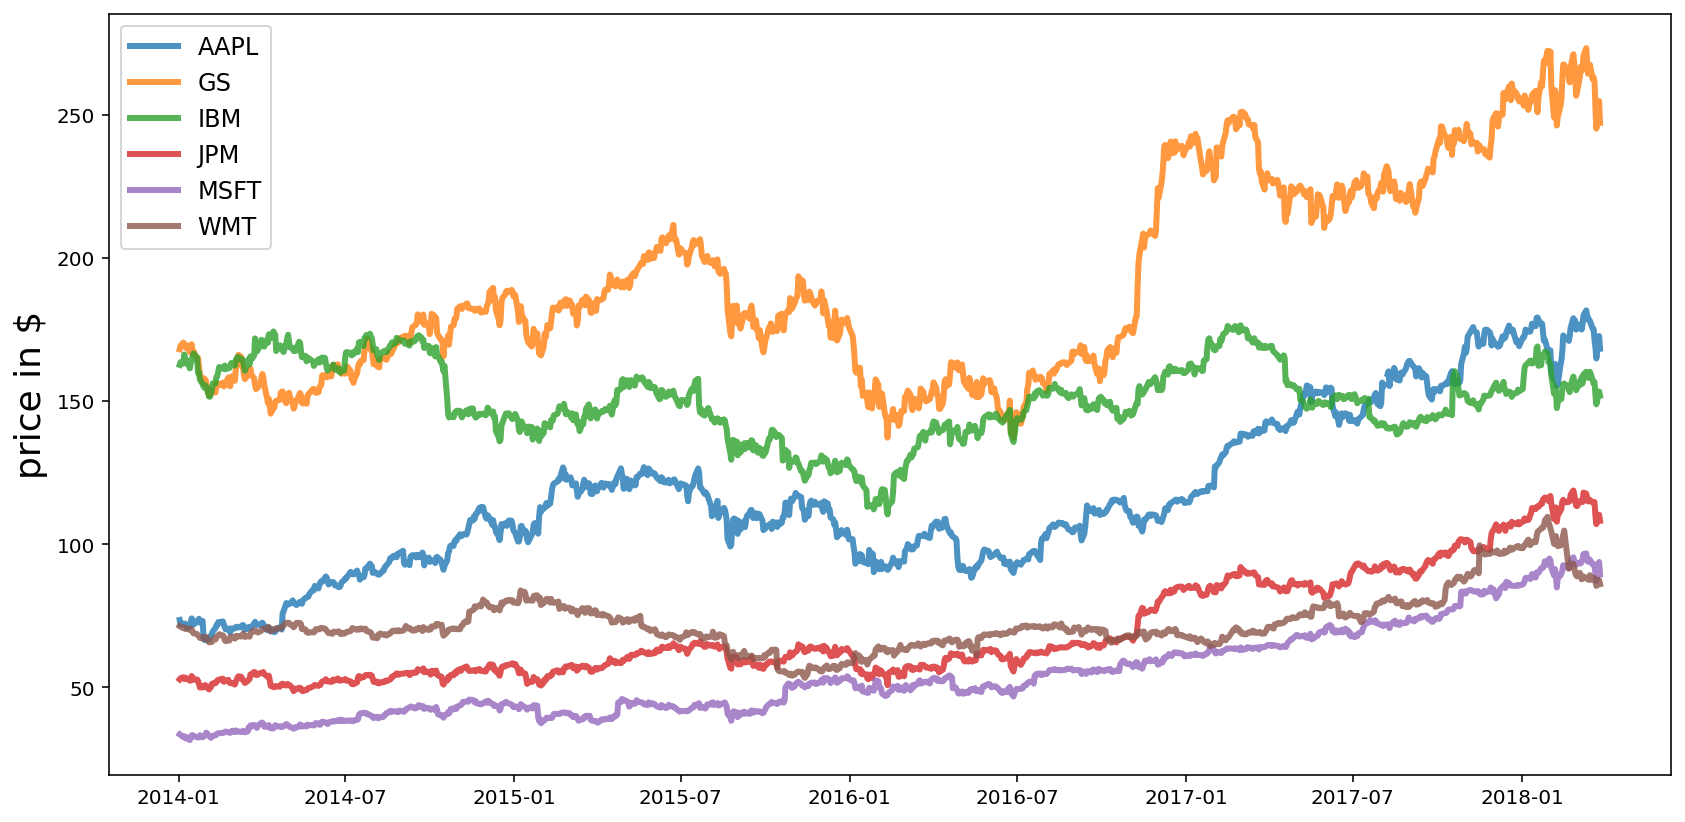

In [6]:
plt.figure(figsize=(14, 7))
for c in table.columns.values:
    plt.plot(table.index, table[c], lw=3, alpha=0.8,label=c)
plt.legend(loc='upper left', fontsize=12)
plt.ylabel('price in $', fontsize=18)

Text(0, 0.5, 'daily returns')

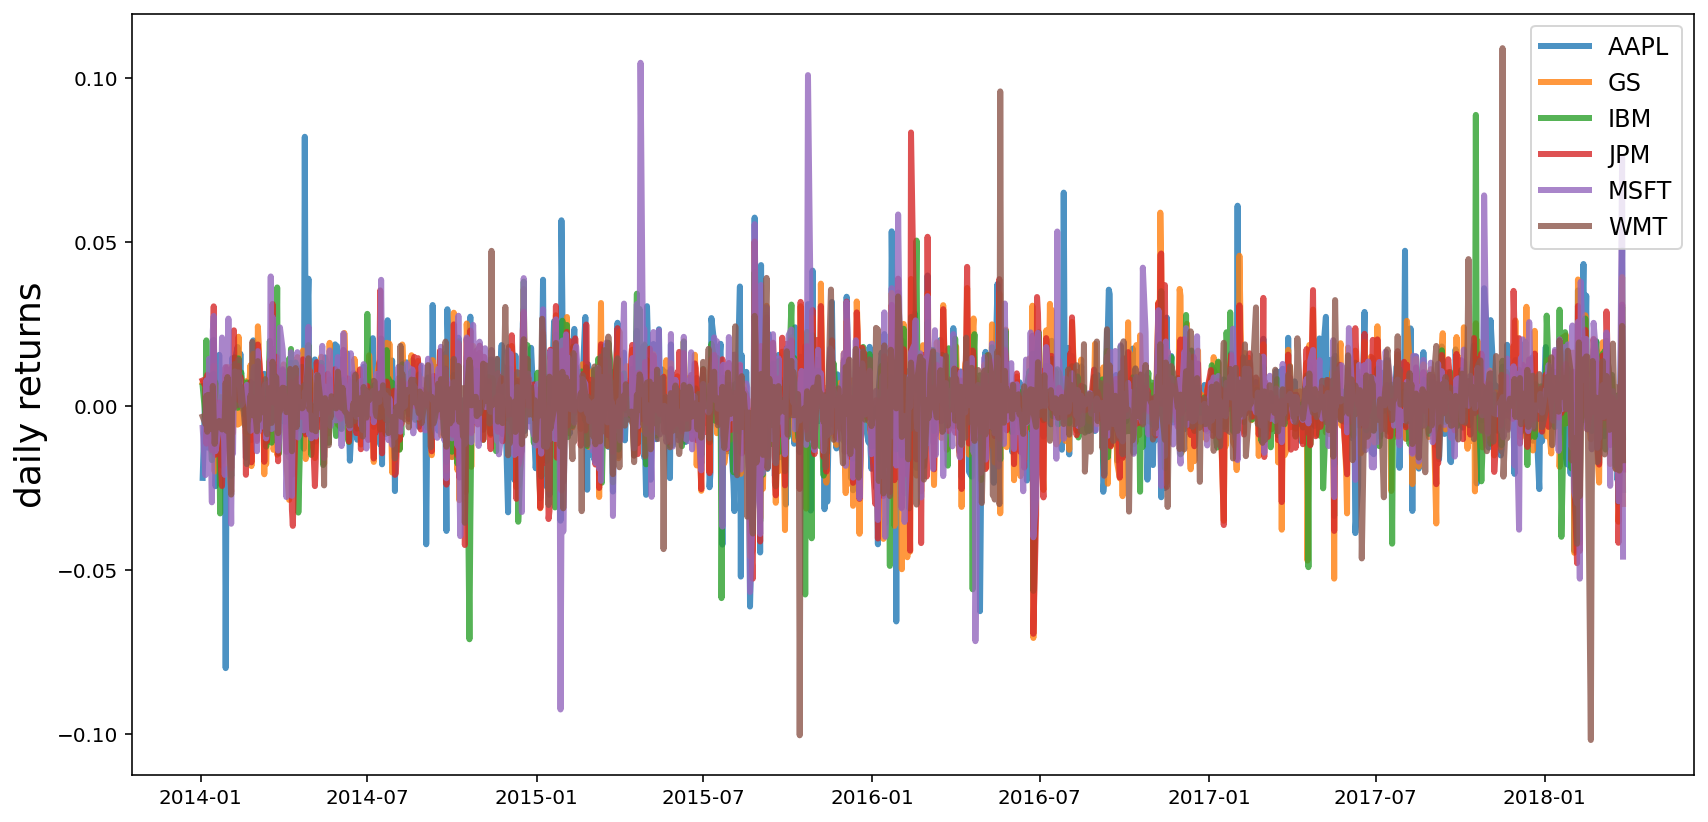

In [7]:
returns = table.pct_change()
plt.figure(figsize=(14, 7))
for c in returns.columns.values:
    plt.plot(returns.index, returns[c], lw=3, alpha=0.8,label=c)
plt.legend(loc='upper right', fontsize=12)
plt.ylabel('daily returns', fontsize=18)

In [8]:
table['AAPL']

date
2014-01-02     73.523423
2014-01-03     71.908415
2014-01-06     72.300536
2014-01-07     71.783135
2014-01-08     72.238063
                 ...    
2018-03-21    171.270000
2018-03-22    168.845000
2018-03-23    164.940000
2018-03-26    172.770000
2018-03-27    168.340000
Name: AAPL, Length: 1065, dtype: float64

Text(0, 0.5, 'Count')

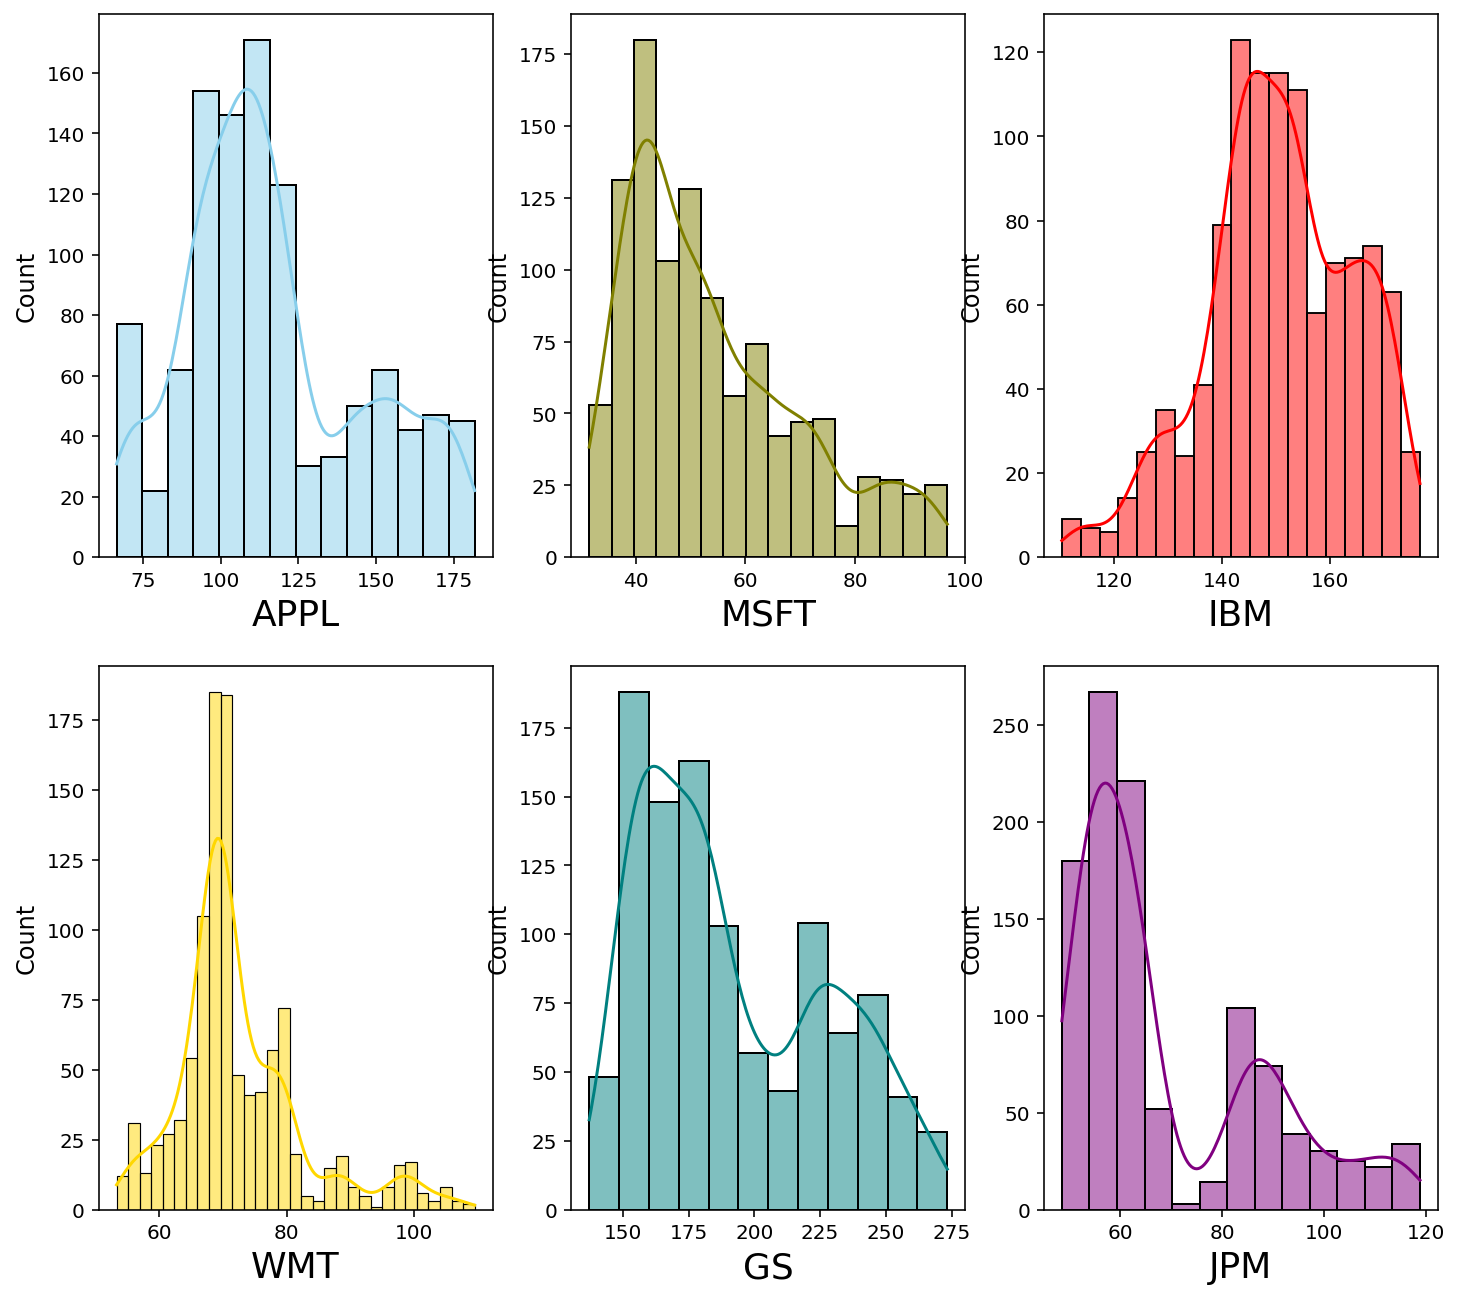

In [9]:
AAPPL_price=table['AAPL']
MSFT_price=table['MSFT']
WMT_price=table['WMT']
GS_price=table['GS']
IBMS_price=table['IBM']
JPM_price=table['JPM']

fig, axs = plt.subplots(2,3, figsize=(12, 11))

hist1=sns.histplot(data=AAPPL_price,  kde=True, color="skyblue", ax=axs[0,0])
hist2=sns.histplot(data=MSFT_price,kde=True, color="olive", ax=axs[0,1])
hist3=sns.histplot(data=WMT_price, kde=True, color="gold", ax=axs[1,0])
hist4=sns.histplot(data=GS_price,  kde=True, color="teal", ax=axs[1,1])
hist5=sns.histplot(data=IBMS_price,  kde=True, color="red", ax=axs[0,2])
hist6=sns.histplot(data=JPM_price,  kde=True, color="purple", ax=axs[1, 2])

hist1.set_xlabel(xlabel="APPL",fontsize=18)
hist1.set_ylabel(ylabel="Count",fontsize=12)

hist2.set_xlabel(xlabel="MSFT",fontsize=18)
hist2.set_ylabel(ylabel="Count",fontsize=12)

hist3.set_xlabel(xlabel="WMT",fontsize=18)
hist3.set_ylabel(ylabel="Count",fontsize=12)

hist4.set_xlabel(xlabel="GS",fontsize=18)
hist4.set_ylabel(ylabel="Count",fontsize=12)

hist5.set_xlabel(xlabel="IBM",fontsize=18)
hist5.set_ylabel(ylabel="Count",fontsize=12)

hist6.set_xlabel(xlabel="JPM",fontsize=18)
hist6.set_ylabel(ylabel="Count",fontsize=12)

# plt.close()


<AxesSubplot:>

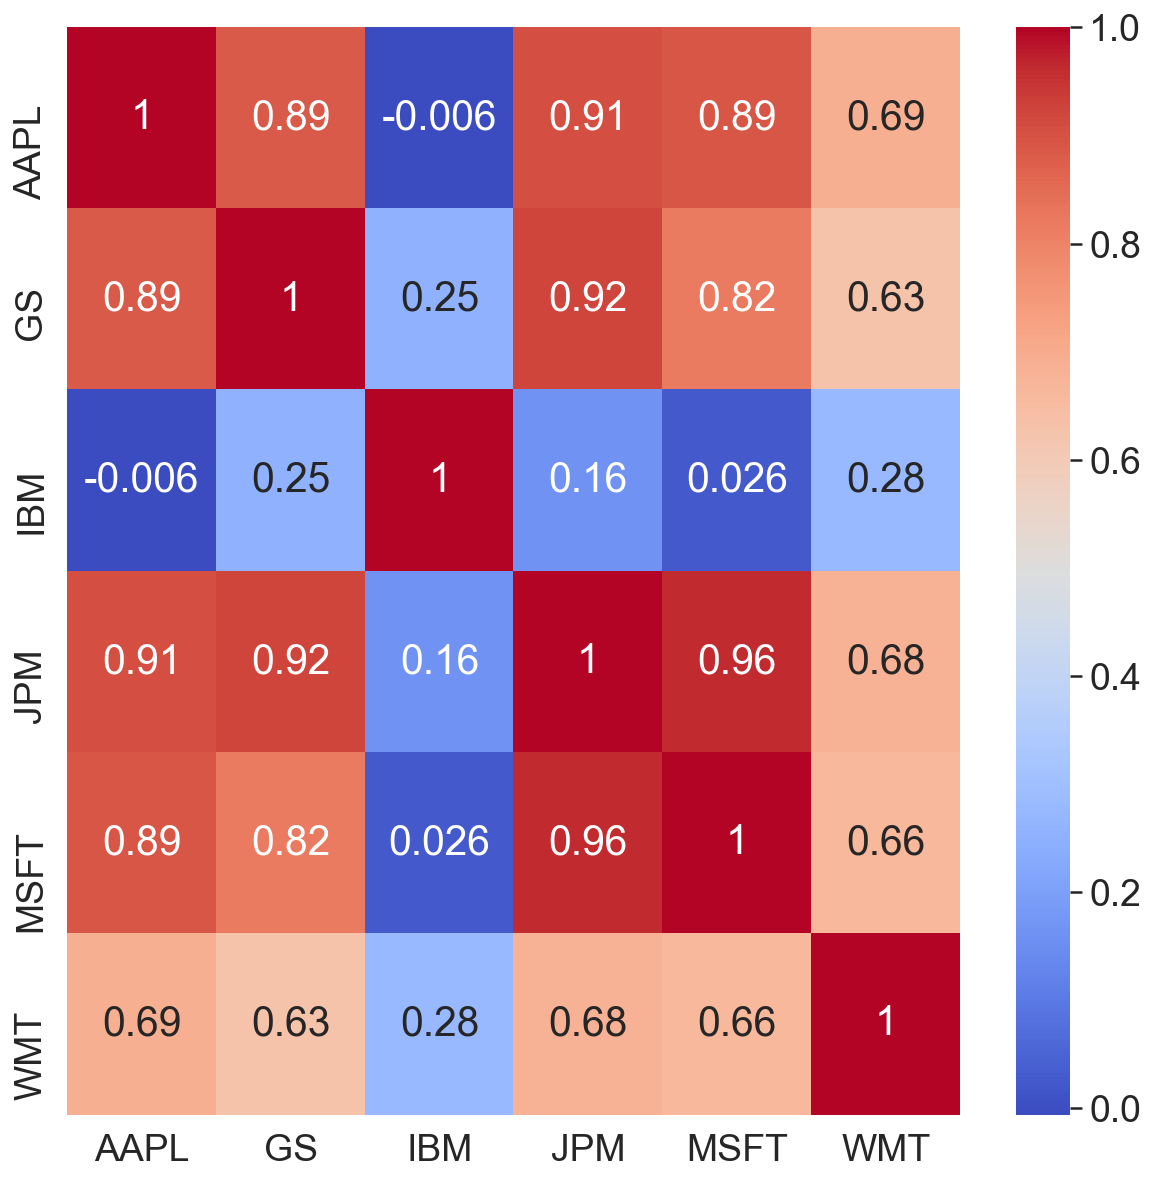

In [10]:
returns = table.pct_change()
mean_returns = returns.mean()
cov_matrix = returns.cov()*252
plt.figure(figsize = (10,10))
sns.set(font_scale=1.7)
sns.heatmap(table.corr(),annot=True, cmap="coolwarm")

# Porfolio Selection

## Random Portfolios Generation

In [11]:
def portfolio_annualised_performance(weights, mean_returns, cov_matrix):
    returns = np.sum(mean_returns*weights ) *252
    std = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights))) * np.sqrt(252)
    return std, returns

In [12]:
def random_portfolios(num_portfolios, mean_returns, cov_matrix, risk_free_rate):
    results = np.zeros((3,num_portfolios))
    weights_record = []
    for i in range(num_portfolios):
        weights = np.random.random(6)
        weights /= np.sum(weights)
        weights_record.append(weights)
        portfolio_std_dev, portfolio_return = portfolio_annualised_performance(weights, mean_returns, cov_matrix)
        results[0,i] = portfolio_std_dev
        results[1,i] = portfolio_return
        results[2,i] = (portfolio_return - risk_free_rate) / portfolio_std_dev
    return results, weights_record

In [13]:
returns = table.pct_change()
mean_returns = returns.mean()
cov_matrix = returns.cov()
num_portfolios = 10000
risk_free_rate = 0.0178

In [14]:
results, weights = random_portfolios(num_portfolios,mean_returns, cov_matrix, risk_free_rate)
max_sharpe_idx = np.argmax(results[2])

max_sharpe_idx

5890

In [15]:
max(results[2])

1.1503506480820282

In [16]:
def display_simulated_ef_with_random(mean_returns, cov_matrix, num_portfolios, risk_free_rate):
    results, weights = random_portfolios(num_portfolios,mean_returns, cov_matrix, risk_free_rate)
    
    max_sharpe_idx = np.argmax(results[2])
    sdp, rp = results[0,max_sharpe_idx], results[1,max_sharpe_idx]
    max_sharpe_allocation = pd.DataFrame(weights[max_sharpe_idx],index=table.columns,columns=['allocation'])
    max_sharpe_allocation.allocation = [round(i*100,2)for i in max_sharpe_allocation.allocation]
    max_sharpe_allocation = max_sharpe_allocation.T
    
    min_vol_idx = np.argmin(results[0])
    sdp_min, rp_min = results[0,min_vol_idx], results[1,min_vol_idx]
    min_vol_allocation = pd.DataFrame(weights[min_vol_idx],index=table.columns,columns=['allocation'])
    min_vol_allocation.allocation = [round(i*100,2)for i in min_vol_allocation.allocation]
    min_vol_allocation = min_vol_allocation.T
    
    print ("-"*80)
    print ("Maximum Sharpe Ratio Portfolio Allocation\n")
    print ("Annualised Return:", round(rp,2))
    print ("Annualised Volatility:", round(sdp,2))
    print ("\n")
    print (max_sharpe_allocation)
    print ("-"*80)
    print ("Minimum Volatility Portfolio Allocation\n")
    print ("Annualised Return:", round(rp_min,2))
    print ("Annualised Volatility:", round(sdp_min,2))
    print ("\n")
    print (min_vol_allocation)
    
    plt.figure(figsize=(10, 7))
    plt.scatter(results[0,:],results[1,:],c=results[2,:],cmap='PuBuGn', marker='o', s=10, alpha=0.3)
    plt.colorbar()
    plt.scatter(sdp,rp,marker='*',color='r',s=500, label='Maximum Sharpe ratio')
    plt.scatter(sdp_min,rp_min,marker='*',color='g',s=500, label='Minimum volatility')
    plt.title('Simulated Portfolio Optimization based on Efficient Frontier')
    plt.xlabel('annualised volatility')
    plt.ylabel('annualised returns')
    plt.legend(labelspacing=0.8)

--------------------------------------------------------------------------------
Maximum Sharpe Ratio Portfolio Allocation

Annualised Return: 0.21
Annualised Volatility: 0.17


             AAPL    GS   IBM    JPM   MSFT   WMT
allocation  30.01  1.37  0.27  28.89  31.39  8.07
--------------------------------------------------------------------------------
Minimum Volatility Portfolio Allocation

Annualised Return: 0.11
Annualised Volatility: 0.14


             AAPL    GS    IBM   JPM  MSFT    WMT
allocation  19.36  2.56  25.49  9.71  6.94  35.95


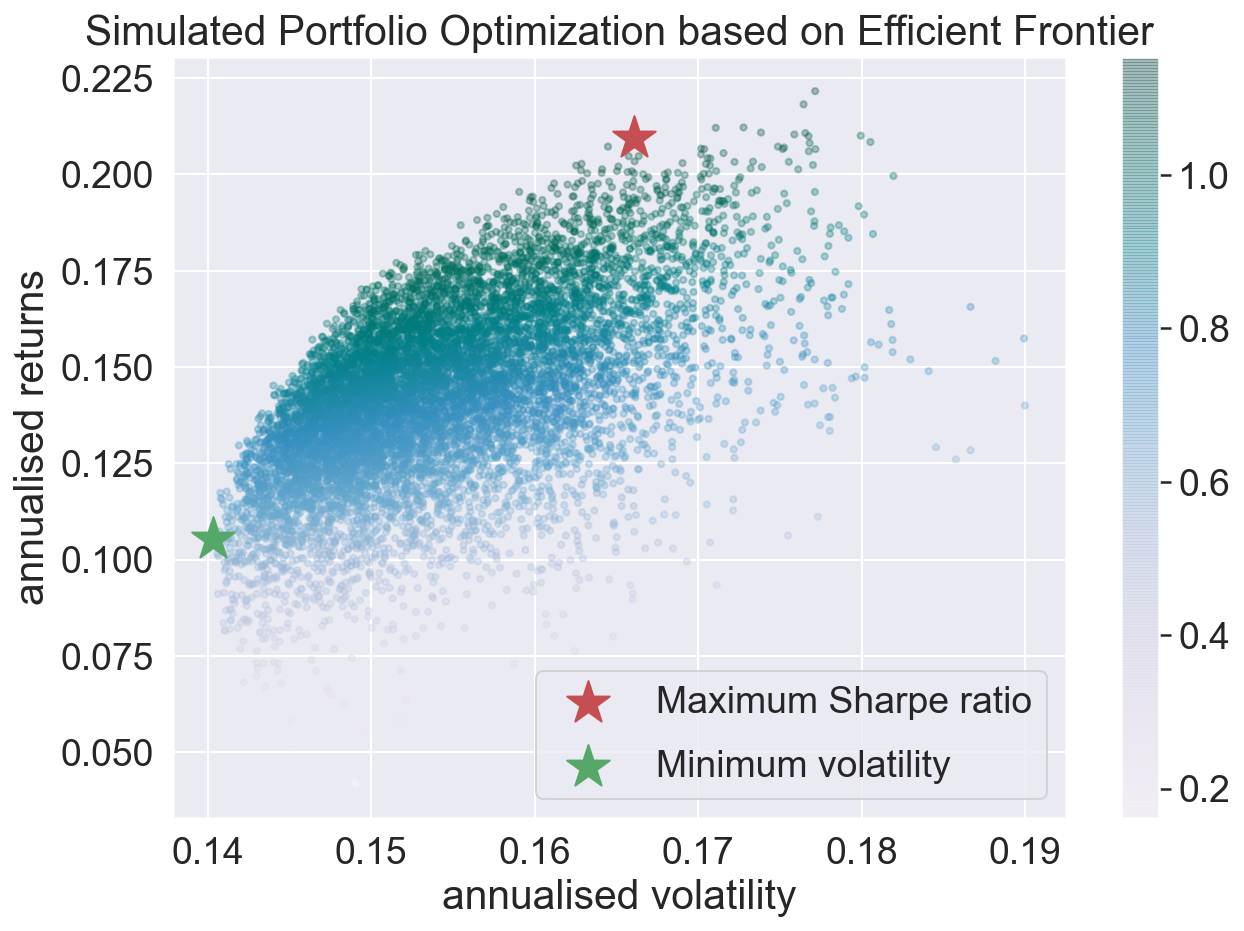

In [17]:
display_simulated_ef_with_random(mean_returns, cov_matrix, num_portfolios, risk_free_rate)

--------------------------------------------------------------------------------
Maximum Sharpe Ratio Portfolio Allocation

Return: 0.22
Volatility: 0.17


             AAPL    GS   IBM    JPM  MSFT   WMT
allocation  21.87  2.17  2.39  26.41  44.0  3.16
--------------------------------------------------------------------------------
Minimum Volatility Portfolio Allocation

Return: 0.09
Volatility: 0.14


             AAPL     GS    IBM   JPM  MSFT    WMT
allocation  13.28  10.09  25.27  4.43  6.78  40.15


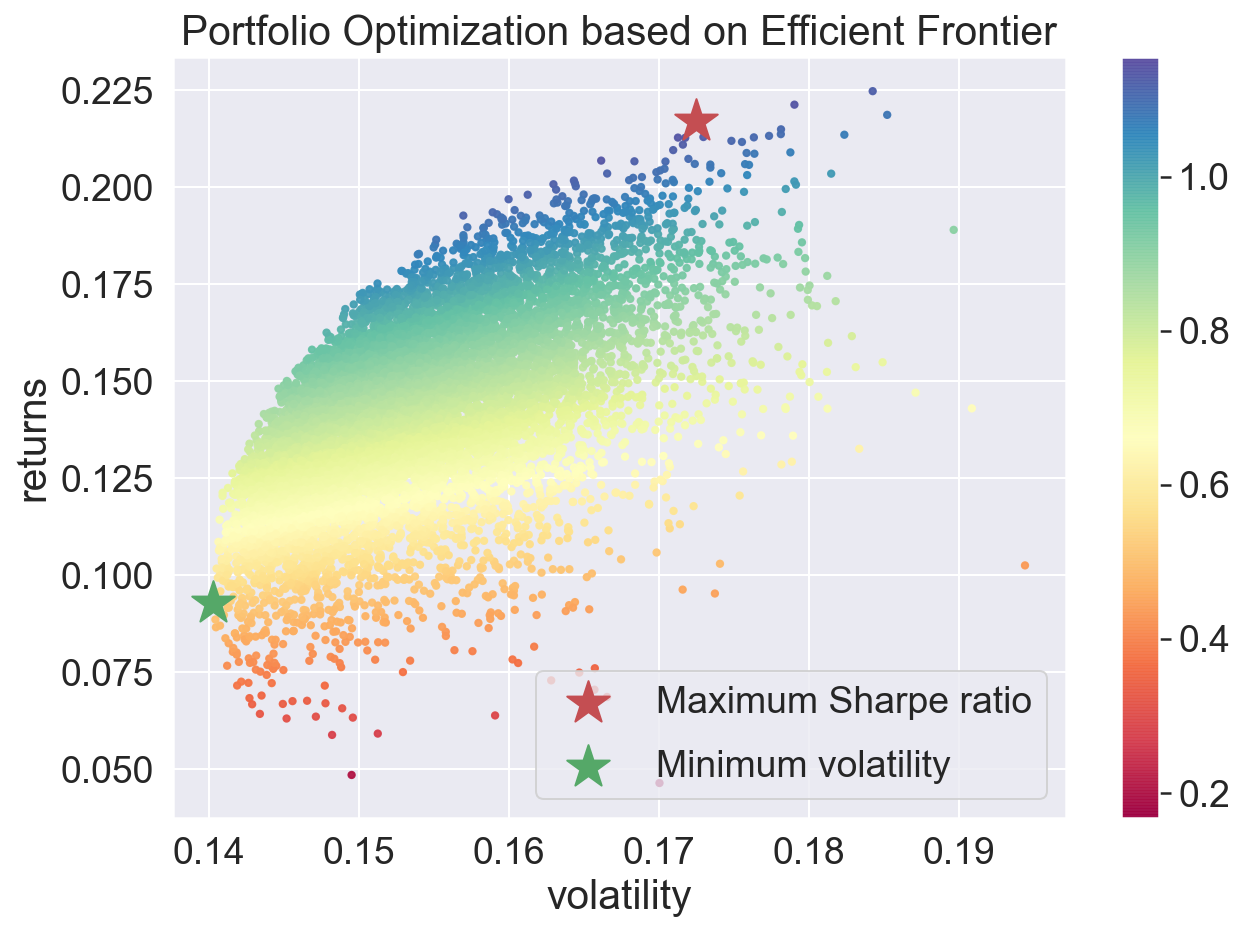

In [18]:
def display_simulated_ef_with_random(mean_returns, cov_matrix, num_portfolios, risk_free_rate):
    results, weights = random_portfolios(num_portfolios,mean_returns, cov_matrix, risk_free_rate)
    
    max_sharpe_idx = np.argmax(results[2])
    sdp, rp = results[0,max_sharpe_idx], results[1,max_sharpe_idx]
    max_sharpe_allocation = pd.DataFrame(weights[max_sharpe_idx],index=table.columns,columns=['allocation'])
    max_sharpe_allocation.allocation = [round(i*100,2)for i in max_sharpe_allocation.allocation]
    max_sharpe_allocation = max_sharpe_allocation.T
    
    min_vol_idx = np.argmin(results[0])
    sdp_min, rp_min = results[0,min_vol_idx], results[1,min_vol_idx]
    min_vol_allocation = pd.DataFrame(weights[min_vol_idx],index=table.columns,columns=['allocation'])
    min_vol_allocation.allocation = [round(i*100,2)for i in min_vol_allocation.allocation]
    min_vol_allocation = min_vol_allocation.T
    
    print ("-"*80)
    print ("Maximum Sharpe Ratio Portfolio Allocation\n")
    print ("Return:", round(rp,2))
    print ("Volatility:", round(sdp,2))
    print ("\n")
    print (max_sharpe_allocation)
    print ("-"*80)
    print ("Minimum Volatility Portfolio Allocation\n")
    print ("Return:", round(rp_min,2))
    print ("Volatility:", round(sdp_min,2))
    print ("\n")
    print (min_vol_allocation)
    
    plt.figure(figsize=(10, 7))
    plt.scatter(results[0,:],results[1,:],c=results[2,:],cmap='Spectral', marker='o', s=10, alpha=0.95)
    plt.colorbar()
    plt.scatter(sdp,rp,marker='*',color='r',s=500, label='Maximum Sharpe ratio')
    plt.scatter(sdp_min,rp_min,marker='*',color='g',s=500, label='Minimum volatility')
    plt.title('Portfolio Optimization based on Efficient Frontier')
    plt.xlabel('volatility')
    plt.ylabel('returns')
    plt.legend(labelspacing=0.8)
    
display_simulated_ef_with_random(mean_returns, cov_matrix, num_portfolios, risk_free_rate)

In [19]:
results, weights = random_portfolios(num_portfolios,mean_returns, cov_matrix, risk_free_rate)
    
max_sharpe_idx = np.argmax(results[2])
sdp, rp = results[0,max_sharpe_idx], results[1,max_sharpe_idx]
max_sharpe_allocation = pd.DataFrame(weights[max_sharpe_idx],index=table.columns,columns=['allocation'])
max_sharpe_allocation.allocation = [round(i*100,2)for i in max_sharpe_allocation.allocation]
max_sharpe_allocation = max_sharpe_allocation.T
    
min_vol_idx = np.argmin(results[0])
sdp_min, rp_min = results[0,min_vol_idx], results[1,min_vol_idx]
min_vol_allocation = pd.DataFrame(weights[min_vol_idx],index=table.columns,columns=['allocation'])
min_vol_allocation.allocation = [round(i*100,2)for i in min_vol_allocation.allocation]
min_vol_allocation = min_vol_allocation.T

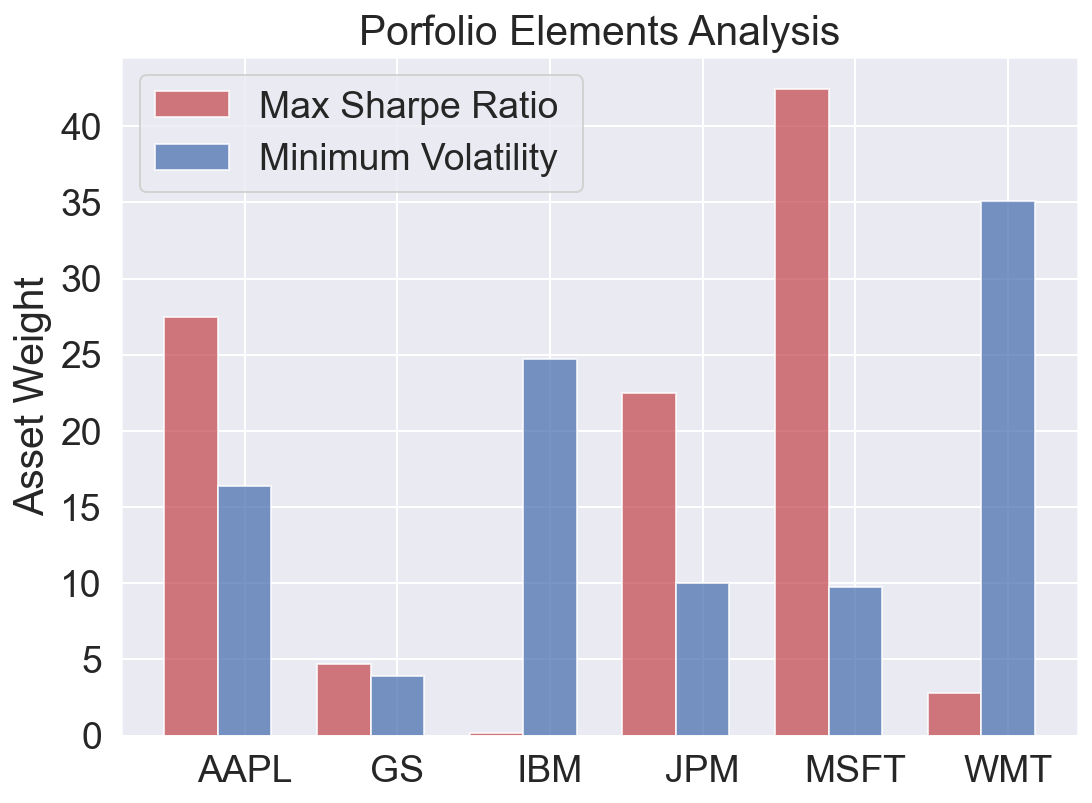

In [20]:
stocks=['AAPL', 'GS','IBM','JPM','MSFT','WMT']
numAssets=len(stocks)
#plt.figure(figsize=(8,6))
ind = np.arange(numAssets)
width = 0.35
fig, ax = plt.subplots(figsize=(8,6))
rects1 = ax.bar(ind, max_sharpe_allocation.iloc[0], width, color='r', alpha=0.75)
rects2 = ax.bar(ind + width, min_vol_allocation.iloc[0], width, color='b', alpha=0.75)
ax.set_ylabel('Asset Weight')
# ax.set_ylim(0,0.6)
ax.set_title('Porfolio Elements Analysis')
ax.set_xticks(ind + width)
ax.set_xticklabels(stocks)
plt.tight_layout()
ax.legend((rects1[0], rects2[0]), ('Max Sharpe Ratio', 'Minimum Volatility '))
# plt.savefig('Portfolio Compositions', dpi=100)
plt.show()

In [21]:
def neg_sharpe_ratio(weights, mean_returns, cov_matrix, risk_free_rate):
    p_var, p_ret = portfolio_annualised_performance(weights, mean_returns, cov_matrix)
    return -(p_ret - risk_free_rate) / p_var

def max_sharpe_ratio(mean_returns, cov_matrix, risk_free_rate):
    num_assets = len(mean_returns)
    args = (mean_returns, cov_matrix, risk_free_rate)
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bound = (0.0,1.0)
    bounds = tuple(bound for asset in range(num_assets))
    result = sco.minimize(neg_sharpe_ratio, num_assets*[1./num_assets,], args=args,
                        method='SLSQP', bounds=bounds, constraints=constraints)
    return result
def portfolio_volatility(weights, mean_returns, cov_matrix):
    return portfolio_annualised_performance(weights, mean_returns, cov_matrix)[0]

def min_variance(mean_returns, cov_matrix):
    num_assets = len(mean_returns)
    args = (mean_returns, cov_matrix)
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bound = (0.0,1.0)
    bounds = tuple(bound for asset in range(num_assets))

    result = sco.minimize(portfolio_volatility, num_assets*[1./num_assets,], args=args,
                        method='SLSQP', bounds=bounds, constraints=constraints)

    return result
def efficient_return(mean_returns, cov_matrix, target):
    num_assets = len(mean_returns)
    args = (mean_returns, cov_matrix)

    def portfolio_return(weights):
        return portfolio_annualised_performance(weights, mean_returns, cov_matrix)[1]

    constraints = ({'type': 'eq', 'fun': lambda x: portfolio_return(x) - target},
                   {'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bounds = tuple((0,1) for asset in range(num_assets))
    result = sco.minimize(portfolio_volatility, num_assets*[1./num_assets,], args=args, method='SLSQP', bounds=bounds, constraints=constraints)
    return result


def efficient_frontier(mean_returns, cov_matrix, returns_range):
    efficients = []
    for ret in returns_range:
        efficients.append(efficient_return(mean_returns, cov_matrix, ret))
    return efficients

--------------------------------------------------------------------------------
Maximum Sharpe Ratio Portfolio Allocation

Annualised Return: 0.23
Annualised Volatility: 0.18


             AAPL   GS  IBM    JPM   MSFT  WMT
allocation  28.43  0.0  0.0  23.63  47.95  0.0
--------------------------------------------------------------------------------
Minimum Volatility Portfolio Allocation

Annualised Return: 0.1
Annualised Volatility: 0.14


             AAPL    GS    IBM   JPM  MSFT    WMT
allocation  14.47  5.54  26.68  9.57  7.22  36.53


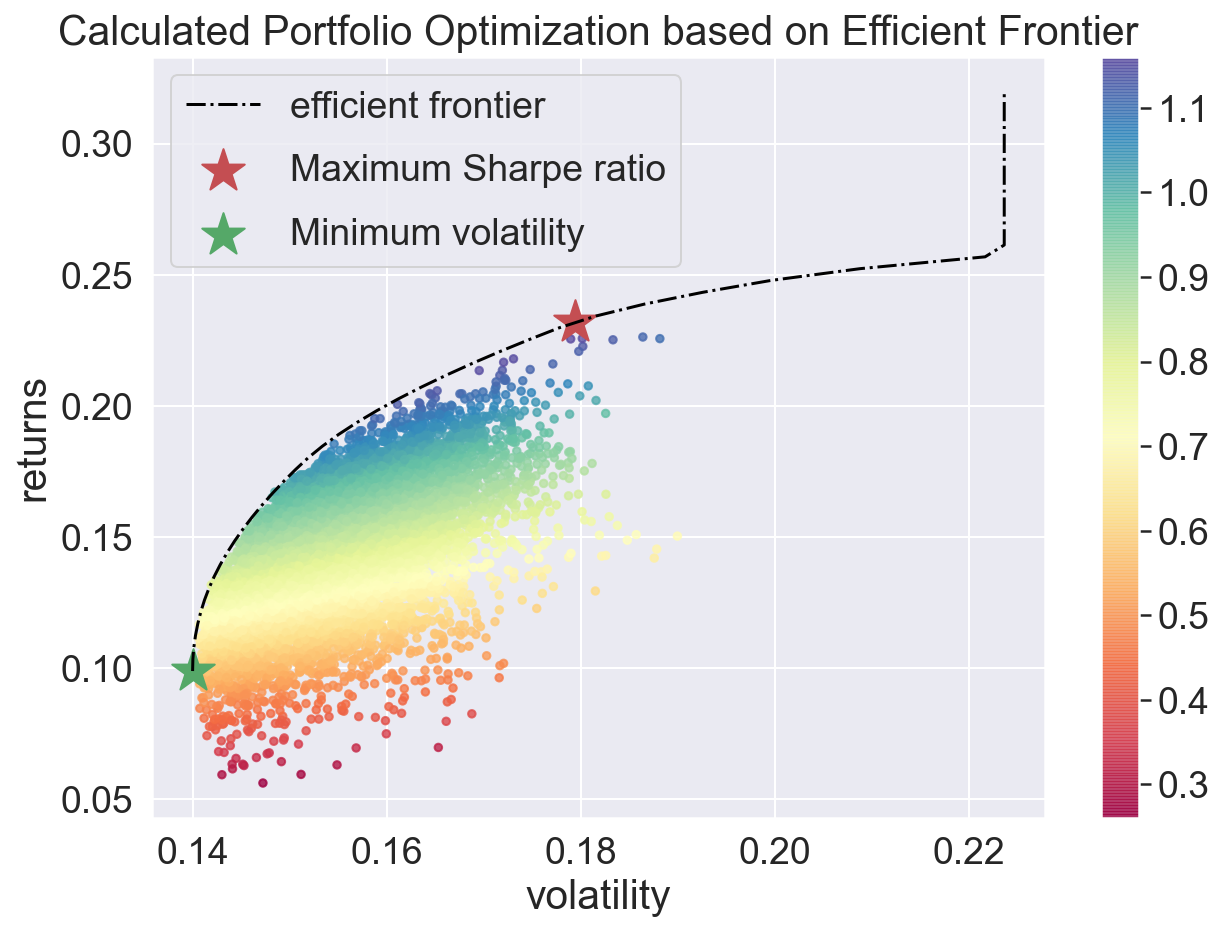

In [22]:
def display_calculated_ef_with_random(mean_returns, cov_matrix, num_portfolios, risk_free_rate):
    results, _ = random_portfolios(num_portfolios,mean_returns, cov_matrix, risk_free_rate)
    
    max_sharpe = max_sharpe_ratio(mean_returns, cov_matrix, risk_free_rate)
    sdp, rp = portfolio_annualised_performance(max_sharpe['x'], mean_returns, cov_matrix)
    max_sharpe_allocation = pd.DataFrame(max_sharpe.x,index=table.columns,columns=['allocation'])
    max_sharpe_allocation.allocation = [round(i*100,2)for i in max_sharpe_allocation.allocation]
    max_sharpe_allocation = max_sharpe_allocation.T
    max_sharpe_allocation

    min_vol = min_variance(mean_returns, cov_matrix)
    sdp_min, rp_min = portfolio_annualised_performance(min_vol['x'], mean_returns, cov_matrix)
    min_vol_allocation = pd.DataFrame(min_vol.x,index=table.columns,columns=['allocation'])
    min_vol_allocation.allocation = [round(i*100,2)for i in min_vol_allocation.allocation]
    min_vol_allocation = min_vol_allocation.T
    
    print ("-"*80)
    print ("Maximum Sharpe Ratio Portfolio Allocation\n")
    print ("Annualised Return:", round(rp,2))
    print ("Annualised Volatility:", round(sdp,2))
    print ("\n")
    print (max_sharpe_allocation)
    print ("-"*80)
    print ("Minimum Volatility Portfolio Allocation\n")
    print ("Annualised Return:", round(rp_min,2))
    print ("Annualised Volatility:", round(sdp_min,2))
    print ("\n")
    print (min_vol_allocation)
    
    plt.figure(figsize=(10, 7))
    plt.scatter(results[0,:],results[1,:],c=results[2,:],cmap='Spectral', marker='o', s=14, alpha=0.8)
    plt.colorbar()
    plt.scatter(sdp,rp,marker='*',color='r',s=500, label='Maximum Sharpe ratio')
    plt.scatter(sdp_min,rp_min,marker='*',color='g',s=500, label='Minimum volatility')

    target = np.linspace(rp_min, 0.32, 50)
    efficient_portfolios = efficient_frontier(mean_returns, cov_matrix, target)
    plt.plot([p['fun'] for p in efficient_portfolios], target, linestyle='-.', color='black', label='efficient frontier')
    plt.title('Calculated Portfolio Optimization based on Efficient Frontier')
    plt.xlabel('volatility')
    plt.ylabel('returns')
    plt.legend(labelspacing=0.8)

    
display_calculated_ef_with_random(mean_returns, cov_matrix, num_portfolios, risk_free_rate)

In [23]:
def display_ef_with_selected(mean_returns, cov_matrix, risk_free_rate):
    
    results, _ = random_portfolios(num_portfolios,mean_returns, cov_matrix, risk_free_rate)
    
    max_sharpe = max_sharpe_ratio(mean_returns, cov_matrix, risk_free_rate)
    sdp, rp = portfolio_annualised_performance(max_sharpe['x'], mean_returns, cov_matrix)
    max_sharpe_allocation = pd.DataFrame(max_sharpe.x,index=table.columns,columns=['allocation'])
    max_sharpe_allocation.allocation = [round(i*100,2)for i in max_sharpe_allocation.allocation]
    max_sharpe_allocation = max_sharpe_allocation.T
    max_sharpe_allocation

    min_vol = min_variance(mean_returns, cov_matrix)
    sdp_min, rp_min = portfolio_annualised_performance(min_vol['x'], mean_returns, cov_matrix)
    min_vol_allocation = pd.DataFrame(min_vol.x,index=table.columns,columns=['allocation'])
    min_vol_allocation.allocation = [round(i*100,2)for i in min_vol_allocation.allocation]
    min_vol_allocation = min_vol_allocation.T
    
    an_vol = np.std(returns) * np.sqrt(252)
    an_rt = mean_returns * 252
    
    print ("-"*80)
    print ("Maximum Sharpe Ratio Portfolio Allocation\n")
    print ("Annualised Return:", round(rp,2))
    print ("Annualised Volatility:", round(sdp,2))
    print ("\n")
    print (max_sharpe_allocation)
    print ("-"*80)
    print ("Minimum Volatility Portfolio Allocation\n")
    print ("Annualised Return:", round(rp_min,2))
    print ("Annualised Volatility:", round(sdp_min,2))
    print ("\n")
    print (min_vol_allocation)
    print ("-"*80)
    print ("Individual Stock Returns and Volatility\n")
    for i, txt in enumerate(table.columns):
        print (txt,":","return",round(an_rt[i],2),", volatility:",round(an_vol[i],2))
    print ("-"*80)
    
    fig, ax = plt.subplots(figsize=(10, 7))
    ax.scatter(an_vol,an_rt,marker='o',s=200)
    
    

    for i, txt in enumerate(table.columns):
        ax.annotate(txt, (an_vol[i],an_rt[i]), xytext=(10,0), textcoords='offset points')
    ax.scatter(sdp,rp,marker='*',color='r',s=500, label='Maximum Sharpe ratio')
    ax.scatter(sdp_min,rp_min,marker='*',color='g',s=500, label='Minimum volatility')

    target = np.linspace(rp_min, 0.34, 50)
    efficient_portfolios = efficient_frontier(mean_returns, cov_matrix, target)
    ax.plot([p['fun'] for p in efficient_portfolios], target, linestyle='-.', color='black', label='efficient frontier')
    ax.set_title('Portfolio Optimization based on Efficient Frontier with Individual Assets')
    ax.set_xlabel('volatility')
    ax.set_ylabel('returns')
    ax.legend(labelspacing=0.8)
    
#         plt.figure(figsize=(10, 7))
    plt.scatter(results[0,:],results[1,:],c=results[2,:],cmap='Spectral', marker='o', s=14, alpha=0.6)
    plt.colorbar()
#     plt.scatter(sdp,rp,marker='*',color='r',s=500, label='Maximum Sharpe ratio')
#     plt.scatter(sdp_min,rp_min,marker='*',color='g',s=500, label='Minimum volatility')

    target = np.linspace(rp_min, 0.32, 50)
#     efficient_portfolios = efficient_frontier(mean_returns, cov_matrix, target)
#     plt.plot([p['fun'] for p in efficient_portfolios], target, linestyle='-.', color='black', label='efficient frontier')
#     plt.title('Calculated Portfolio Optimization based on Efficient Frontier')
#     plt.xlabel('volatility')
#     plt.ylabel('returns')
#     plt.legend(labelspacing=0.8)

--------------------------------------------------------------------------------
Maximum Sharpe Ratio Portfolio Allocation

Annualised Return: 0.23
Annualised Volatility: 0.18


             AAPL   GS  IBM    JPM   MSFT  WMT
allocation  28.43  0.0  0.0  23.63  47.95  0.0
--------------------------------------------------------------------------------
Minimum Volatility Portfolio Allocation

Annualised Return: 0.1
Annualised Volatility: 0.14


             AAPL    GS    IBM   JPM  MSFT    WMT
allocation  14.47  5.54  26.68  9.57  7.22  36.53
--------------------------------------------------------------------------------
Individual Stock Returns and Volatility

AAPL : return 0.22 , volatility: 0.23
GS : return 0.12 , volatility: 0.22
IBM : return 0.0 , volatility: 0.19
JPM : return 0.19 , volatility: 0.21
MSFT : return 0.26 , volatility: 0.22
WMT : return 0.06 , volatility: 0.19
--------------------------------------------------------------------------------


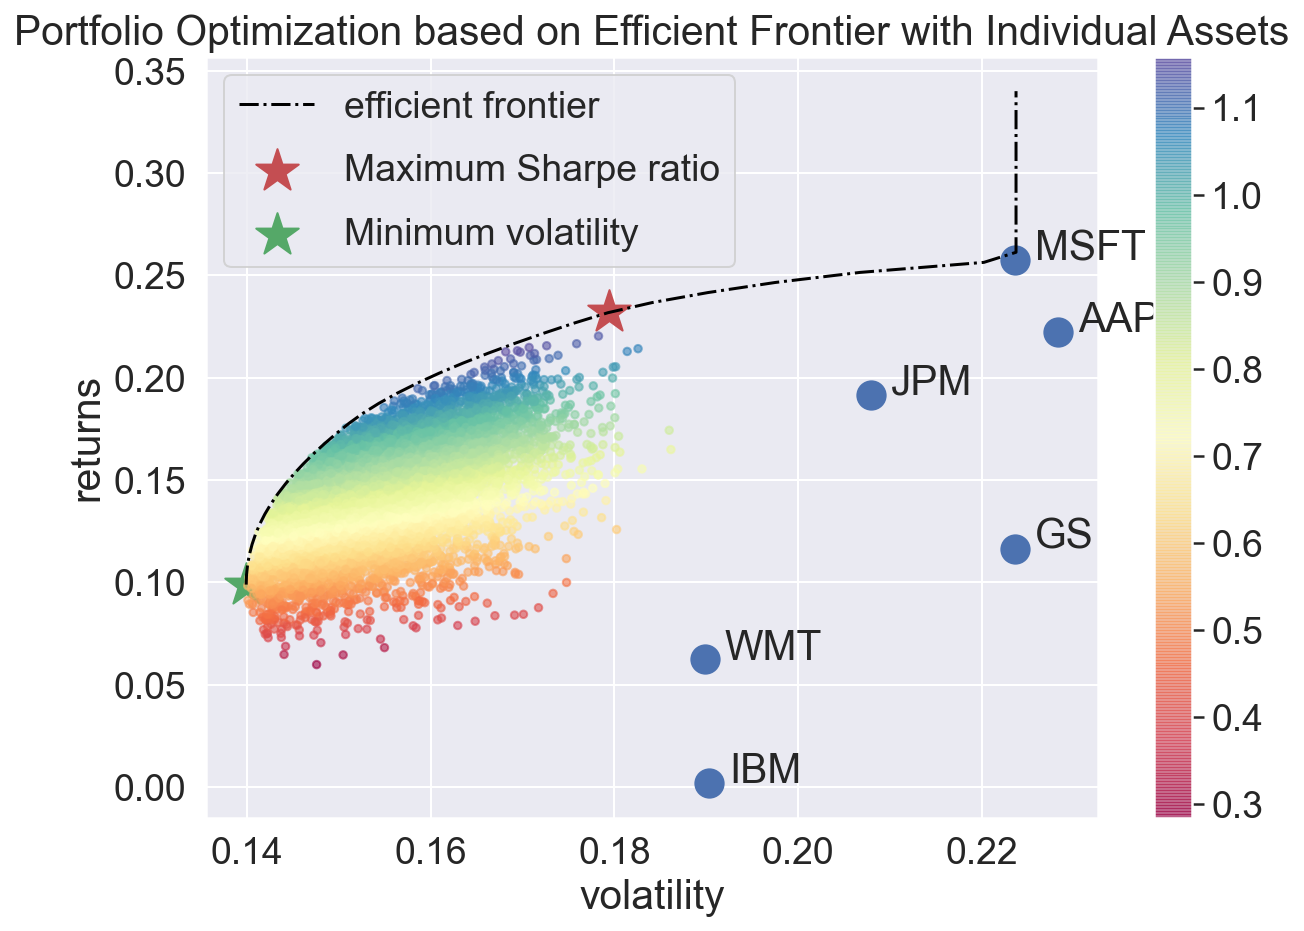

In [24]:
display_ef_with_selected(mean_returns, cov_matrix, risk_free_rate)

In [25]:
max(results[2])

1.1657575668535924

In [26]:
max_sharpe = max_sharpe_ratio(mean_returns, cov_matrix, risk_free_rate)
sdp, rp = portfolio_annualised_performance(max_sharpe['x'], mean_returns, cov_matrix)
max_sharpe_allocation = pd.DataFrame(max_sharpe.x,index=table.columns,columns=['allocation'])
max_sharpe_allocation.allocation = [round(i*100,3)for i in max_sharpe_allocation.allocation]
max_sharpe_allocation = max_sharpe_allocation.T
max_sharpe_allocation

min_vol = min_variance(mean_returns, cov_matrix)
sdp_min, rp_min = portfolio_annualised_performance(min_vol['x'], mean_returns, cov_matrix)
min_vol_allocation = pd.DataFrame(min_vol.x,index=table.columns,columns=['allocation'])
min_vol_allocation.allocation = [round(i*100,3)for i in min_vol_allocation.allocation]
min_vol_allocation = min_vol_allocation.T

an_vol = np.std(returns) * np.sqrt(252)
an_rt = mean_returns * 252

print ("-"*80)
print ("Maximum Sharpe Ratio Portfolio Allocation\n")
print ("Annualised Return:", round(rp,2))
print ("Annualised Volatility:", round(sdp,2))
print ("\n")
print (max_sharpe_allocation)
print ("-"*80)
print ("Minimum Volatility Portfolio Allocation\n")
print ("Annualised Return:", round(rp_min,2))
print ("Annualised Volatility:", round(sdp_min,2))
print ("\n")
print (min_vol_allocation)
print ("-"*80)
print ("Individual Stock Returns and Volatility\n")
for i, txt in enumerate(table.columns):
    print (txt,":","return",round(an_rt[i],2),", volatility:",round(an_vol[i],2))
print ("-"*80)

--------------------------------------------------------------------------------
Maximum Sharpe Ratio Portfolio Allocation

Annualised Return: 0.23
Annualised Volatility: 0.18


              AAPL   GS  IBM    JPM    MSFT  WMT
allocation  28.425  0.0  0.0  23.63  47.945  0.0
--------------------------------------------------------------------------------
Minimum Volatility Portfolio Allocation

Annualised Return: 0.1
Annualised Volatility: 0.14


              AAPL     GS     IBM    JPM   MSFT     WMT
allocation  14.474  5.536  26.677  9.566  7.223  36.525
--------------------------------------------------------------------------------
Individual Stock Returns and Volatility

AAPL : return 0.22 , volatility: 0.23
GS : return 0.12 , volatility: 0.22
IBM : return 0.0 , volatility: 0.19
JPM : return 0.19 , volatility: 0.21
MSFT : return 0.26 , volatility: 0.22
WMT : return 0.06 , volatility: 0.19
--------------------------------------------------------------------------------


In [27]:
an_rt

AAPL    0.222314
GS      0.116466
IBM     0.001961
JPM     0.191712
MSFT    0.257429
WMT     0.062445
dtype: float64

In [28]:
max_sharpe.x

array([28.425,  0.   ,  0.   , 23.63 , 47.945,  0.   ])

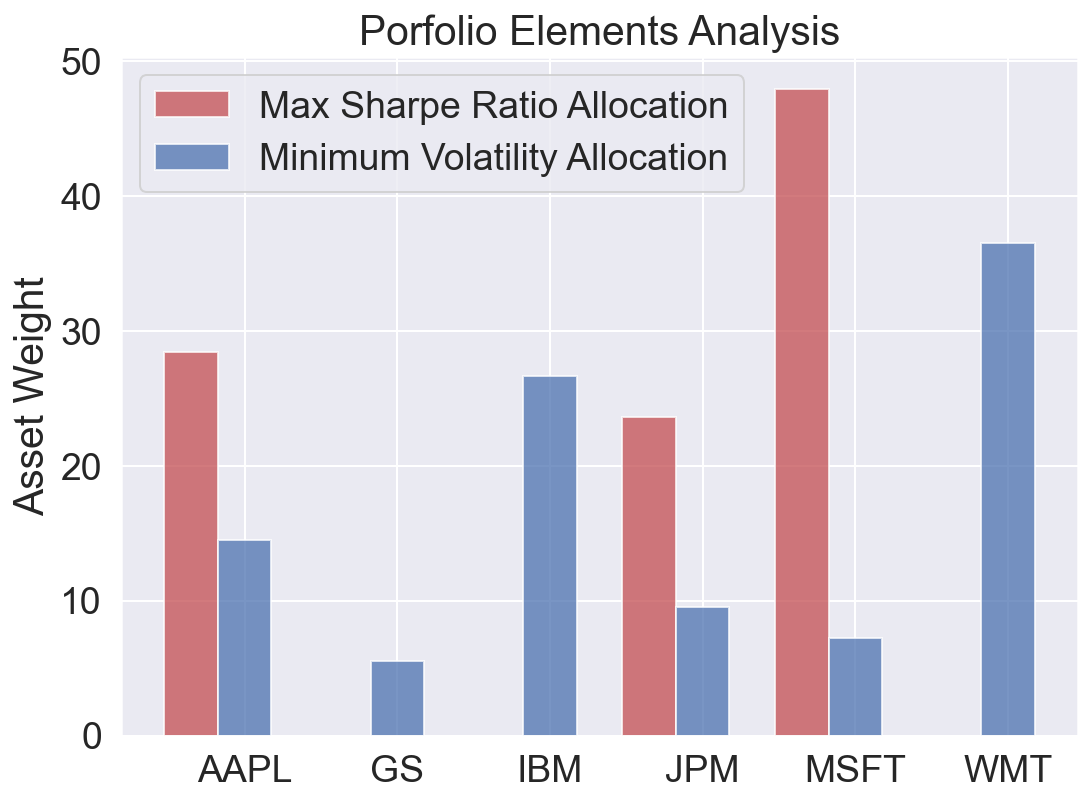

In [29]:
stocks=['AAPL', 'GS','IBM','JPM','MSFT','WMT']
numAssets=len(stocks)
#plt.figure(figsize=(8,6))
ind = np.arange(numAssets)
width = 0.35
fig, ax = plt.subplots(figsize=(8,6))
rects1 = ax.bar(ind, max_sharpe_allocation.iloc[0], width, color='r', alpha=0.75)
rects2 = ax.bar(ind + width, min_vol_allocation.iloc[0], width, color='b', alpha=0.75)
ax.set_ylabel('Asset Weight')
# ax.set_ylim(0,0.6)
ax.set_title('Porfolio Elements Analysis')
ax.set_xticks(ind + width)
ax.set_xticklabels(stocks)
plt.tight_layout()
ax.legend((rects1[0], rects2[0]), ('Max Sharpe Ratio Allocation', 'Minimum Volatility Allocation'))
# plt.savefig('Portfolio Compositions', dpi=100)
plt.show()

## Stock Price Prediction

In [30]:
ms_data = quandl.get_table('WIKI/PRICES', ticker = 'MSFT',
                        qopts = { 'columns': ['date', 'ticker','open','close', 'low','high','adj_close'] },
                        date = { 'gte': '2014-1-1', 'lte': '2020-12-31' }, paginate=True)
ms_data.head()

,date,ticker,open,close,low,high,adj_close
None,,,,,,,
0,2018-03-27,MSFT,94.940,89.47,88.51,95.139,89.47
1,2018-03-26,MSFT,90.610,93.78,90.40,94.000,93.78
2,2018-03-23,MSFT,89.500,87.18,87.08,90.460,87.18
3,2018-03-22,MSFT,91.265,89.79,89.66,91.750,89.79
4,2018-03-21,MSFT,92.930,92.48,92.21,94.050,92.48


In [31]:
ms_df = ms_data.set_index('date')
high=ms_df['high']

In [32]:
high

date
2018-03-27    95.139
2018-03-26    94.000
2018-03-23    90.460
2018-03-22    91.750
2018-03-21    94.050
               ...  
2014-01-08    36.140
2014-01-07    36.490
2014-01-06    36.890
2014-01-03    37.220
2014-01-02    37.400
Name: high, Length: 1065, dtype: float64

Text(0.5, 1.0, 'Plot of high values')

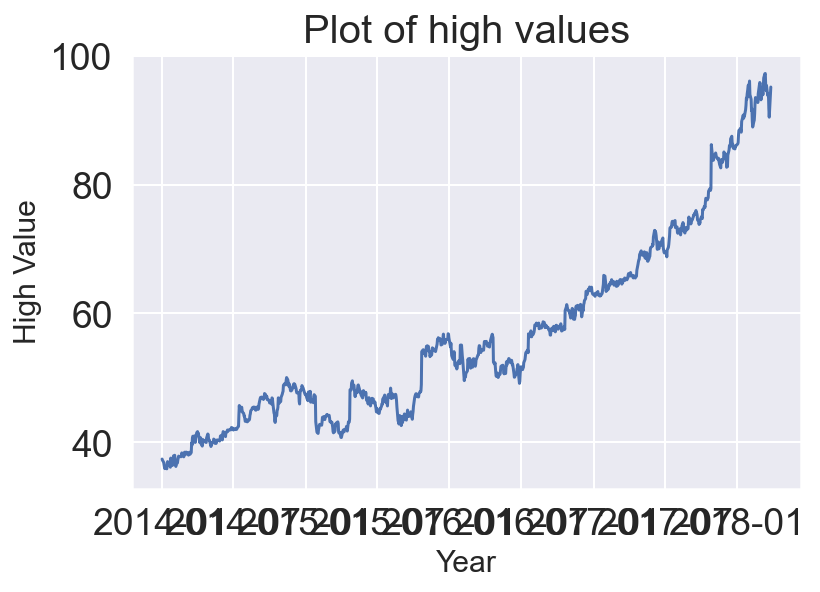

In [33]:
# high=ms_data['high']
plt.plot(high)
plt.xlabel('Year',fontsize=15)
plt.ylabel('High Value',fontsize=15)
plt.title('Plot of high values',fontsize=20)

In [34]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()

high_prices = sc.fit_transform(np.array(high).reshape(-1,1))
high_prices

array([[ 2.60255635],
       [ 2.52572839],
       [ 2.2869479 ],
       ...,
       [-1.32646193],
       [-1.30420273],
       [-1.29206135]])

In [35]:
split_size = 0.65

training_size = int(len(high)*0.65)

train_data = high_prices[0:training_size,:]
test_data = high_prices[training_size:,:]

print(len(train_data))
print(len(test_data))


692
373


In [36]:
#Arranging our data in such a way that the high value of current day depends on the trends in last 60 days.
def create_data(data,timestep=1):
    X,Y = [],[]
    for i in range(len(data)-timestep-1):
        a = data[i:(i+timestep),0]    #i=0,1,2,3,4,.....
        X.append(a)
        Y.append(data[i+timestep,0])
        
    return np.array(X),np.array(Y)


In [37]:
timestep = 60
X_train, Y_train = create_data(train_data, timestep)
x_test, y_test = create_data(test_data, timestep)

print(X_train.shape)
print(Y_train.shape)
print(x_test.shape)
print(y_test.shape)

(631, 60)
(631,)
(312, 60)
(312,)


In [38]:
#Since the LSTM model accepts a 3D tensor so we convert both X_train and x_test into a 3D tensor

X_train = np.reshape(X_train,(X_train.shape[0],X_train.shape[1],1))
x_test = x_test.reshape(x_test.shape[0],x_test.shape[1],1)

print(X_train.shape)
print(x_test.shape)

(631, 60, 1)
(312, 60, 1)


In [39]:
from tensorflow.keras import models
from tensorflow.keras.layers import LSTM,Dense

In [40]:
model = models.Sequential()

model.add(LSTM(64,return_sequences=True,input_shape=(60,1)))
model.add(LSTM(50,return_sequences=True))
model.add(LSTM(32,return_sequences=True))
model.add(LSTM(50,return_sequences=False))
model.add(Dense(1))
model.compile(optimizer='adam',loss='mean_squared_error')
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 60, 64)            16896     
_________________________________________________________________
lstm_1 (LSTM)                (None, 60, 50)            23000     
_________________________________________________________________
lstm_2 (LSTM)                (None, 60, 32)            10624     
_________________________________________________________________
lstm_3 (LSTM)                (None, 50)                16600     
_________________________________________________________________
dense (Dense)                (None, 1)                 51        
Total params: 67,171
Trainable params: 67,171
Non-trainable params: 0
_________________________________________________________________


In [41]:
hist = model.fit(X_train,Y_train,epochs=40,batch_size=32)

Epoch 1/40
20/20 [==============================] - 7s 59ms/step - loss: 0.2714
Epoch 2/40
20/20 [==============================] - 1s 60ms/step - loss: 0.0337
Epoch 3/40
20/20 [==============================] - 1s 61ms/step - loss: 0.0177: 0s - loss
Epoch 4/40
20/20 [==============================] - 1s 61ms/step - loss: 0.0159
Epoch 5/40
20/20 [==============================] - 1s 62ms/step - loss: 0.0173
Epoch 6/40
20/20 [==============================] - 1s 61ms/step - loss: 0.0147
Epoch 7/40
20/20 [==============================] - 1s 64ms/step - loss: 0.0145
Epoch 8/40
20/20 [==============================] - 1s 62ms/step - loss: 0.0135
Epoch 9/40
20/20 [==============================] - 1s 61ms/step - loss: 0.0125
Epoch 10/40
20/20 [==============================] - 1s 61ms/step - loss: 0.0126
Epoch 11/40
20/20 [==============================] - 1s 63ms/step - loss: 0.0123
Epoch 12/40
20/20 [==============================] - 1s 59ms/step - loss: 0.0129
Epoch 13/40
20/20 [=======

In [42]:
y_pred = model.predict(x_test)

print(len(y_pred))
print(type(y_pred))

312
<class 'numpy.ndarray'>


In [43]:
from sklearn.metrics import mean_squared_error

loss = np.sqrt(mean_squared_error(y_test,y_pred))
loss

0.07051944355801784

In [44]:
y_test = sc.inverse_transform(y_test)
y_pred = sc.inverse_transform(y_pred)

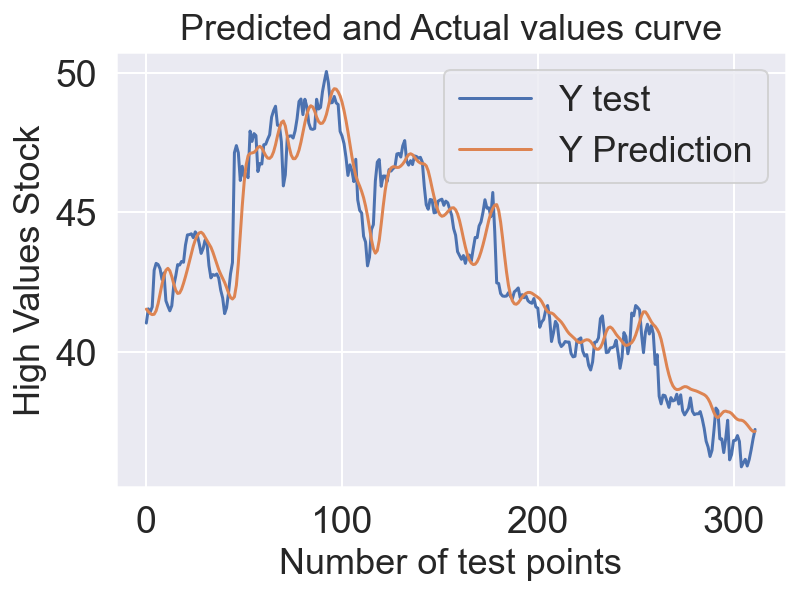

In [45]:
plt.plot(y_test,label='Y test')
plt.plot(y_pred,label='Y Prediction')
plt.title('Predicted and Actual values curve',fontsize='18')
plt.legend(fontsize=18)
plt.xlabel('Number of test points',fontsize='18')
plt.ylabel('High Values Stock',fontsize='18')
plt.show()

In [1]:
y_test

NameError: name 'y_test' is not defined